In [3]:
import os

import keras.models
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Import file
sound_rate, sound_data = wav.read('Datasets/UrbanSoundClassification/fold1/7061-6-0-0.wav')
# Play the signal
print(sound_rate)

44100


In [19]:
len(sound_data.shape)

2

In [20]:
print([x[0] for x in sound_data])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Zero crossing rage feature extraction

In [21]:
def get_sign(number):
  if number <= 0:
    return -1
  else:
    return 1

def get_zero_crossing_rate(sound):
  total = len(sound)
  zero_crossing_num = 0
  for i in range(total - 1):
    current_value_sign = get_sign(sound[i])
    next_value_sign = get_sign(sound[i + 1])
    if current_value_sign != next_value_sign:
      zero_crossing_num += 1
  result = np.array([zero_crossing_num / (total - 1)])
  return result


### Duration feature extraction

In [22]:
def duration(input):
    return np.array(input.shape)

### Energy feature extraction


In [23]:
# def root_mean_square_error(filename)

In [24]:
# energia del segnale
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

In [25]:
# def energy(input):
#     if np.sum((input*1.0)**2, keepdims=True).shape[0] != 1:
#         print(np.sum((input*1.0)**2, keepdims=True).shape)
#     energy_data = np.sum((input*1.0)**2, keepdims=True)
#     print(energy_data.shape)
#     if type(energy_data[0]) != 'numpy.ndarray':
#         return energy_data
#     else:
#         result = energy_data[0]
#         if type(result[0]) != 'numpy.ndarray':
#             return result
#         else:
#             while result.shape != (1,):
#                 result = result[0]
#             return result

In [26]:
# Import file
sound_rate, sound_data = wav.read('Datasets/UrbanSoundClassification/fold1/157867-8-0-6.wav')
# Play the signal
print(sound_rate)

44100


In [27]:
print(energy(sound_data).shape)

(1,)


### MFCCs features extraction

In [28]:
def feats_spectrogram(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.stft(y=trimmed_input)
    Xdb = librosa.amplitude_to_db(abs(X))
    return Xdb.flatten()


def feats_mel(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.feature.melspectrogram(y=trimmed_input, sr=rate)
    S_DB = librosa.power_to_db(X, ref=np.max)
    return S_DB.reshape(S_DB.shape[0] * S_DB.shape[1])


def feats_mfcc(input, rate=2000, tsize=10):
    trimmed_input = feats_temporal(input, rate)
    X = librosa.feature.mfcc(y=trimmed_input, sr=rate)
    return X.reshape(X.shape[0] * X.shape[1])

def feats_temporal(input, size=2000):
    # Remove any values exceeding the given limit
    output = input[0:min(size, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

# Feature extraction

In [29]:
def get_features(input, filename):
    try:
        return np.concatenate((energy(input),duration(input), feats_spectrogram(input,2000), feats_mel(input,2000), feats_mfcc(input,2000)))
    except Exception as e:
        print(e)


In [30]:
#data loading
from tqdm import tqdm
def load_data(feature_extractor=get_features, normalize=False):
    features = []
    labels = []
    x=0
    for f in os.listdir('Datasets/UrbanSoundClassification/'):
        for audio_file in tqdm(os.listdir('Datasets/UrbanSoundClassification/'+f)):
            try:
                if audio_file.endswith('.wav'):
                    _, signal = wav.read('Datasets/UrbanSoundClassification/'+f+'/'+audio_file)
                    if len(signal.shape) == 2:
                        signal = np.asarray([x[0] for x in signal])
                    file_features = get_features(signal, 'Datasets/UrbanSoundClassification/'+f+'/'+audio_file)
                    features.append(file_features)
                    label = audio_file.split('-')[1]
                    labels.append(label)
            except:
                None


    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)
    if normalize:
        eps = 0.001
        x_train = np.array(x_train)
        X_train_mean = x_train.mean(axis=0)
        X_train_std = x_train.std(axis=0)
        x_train = (x_train - X_train_mean + eps)/(X_train_std + eps)
        x_train = [row for row in x_train]

        x_test = [row for row in (np.array(x_test) - X_train_mean + eps)/(X_train_std + eps)]

    return x_train, x_test, y_train, y_test

In [31]:
x_train, x_test, y_train, y_test = load_data(normalize=True)

100%|██████████| 816/816 [00:40<00:00, 20.17it/s]


In [32]:
len(x_train)

7850

In [33]:
np.savez_compressed('./Datasets/UrbanSoundClassification/processed', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

### Classification

In [4]:
dataset = np.load('./Datasets/UrbanSoundClassification/processed.npz', allow_pickle=True)

In [36]:
x_train_list = [x.tolist() for x in dataset['x_train'] ]
y_train_list =   [x.tolist() for x in dataset['y_train'] ]

In [38]:
len(x_train_list)
len(y_train_list)
dataset['x_train'].shape
dataset['y_train'].shape

(7850,)

In [56]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(x_train_list, y_train_list)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 4147.964s


In [57]:
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [58]:
x_test_list = [x.tolist() for x in dataset['x_test'] ]
y_test_list = [x.tolist() for x in dataset['y_test'] ]

In [59]:
y_pred = clf.predict(x_test_list)
print(classification_report(y_test_list, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        96
           1       0.97      0.67      0.79        42
           2       0.66      0.69      0.68       100
           3       0.49      0.68      0.57        90
           4       0.85      0.80      0.83       106
           5       0.90      0.85      0.87       105
           6       0.89      0.73      0.80        33
           7       0.91      0.92      0.92       104
           8       0.88      0.83      0.86       100
           9       0.70      0.68      0.69        97

    accuracy                           0.78       873
   macro avg       0.81      0.77      0.79       873
weighted avg       0.80      0.78      0.79       873



Confusion matrix:


Text(0, 0.5, 'Prediction')

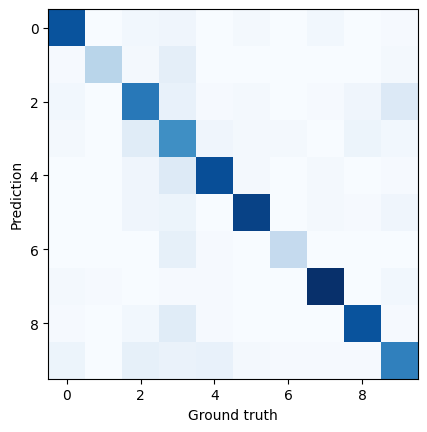

In [60]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [63]:
import pickle

with open("./Datasets/Classifiers/speech/svm1.pickle", "wb+") as f:
    pickle.dump(clf, f)

In [62]:
import pickle

with open("./Datasets/Classifiers/speech/svm.pickle", "rb") as f:
    svm_model = pickle.load(f)

### Multi layer perceptron

In [5]:
from keras.utils import to_categorical

one_hot_train = to_categorical(dataset['y_train'])
one_hot_test = to_categorical(dataset['y_test'])

In [6]:
one_hot_train.shape

(7850, 10)

In [33]:
from keras import regularizers, Input, Model
from keras.layers import Dense, Dropout
reg = regularizers.l2(0.001)
input_layer = Input(shape=( 4694,))
x = Dense(512, activation = 'relu', )(input_layer)
# x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu', )(x)
# x = Dropout(0.4)(x)
x = Dense(128, activation = 'relu', )(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu', )(x)
x = Dropout(0.1)(x)
output = Dense(10, activation = "softmax")(x)

model = Model(input_layer, output)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4694)]            0         
                                                                 
 dense_25 (Dense)            (None, 512)               2403840   
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0   

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
train_data = dataset['x_train']
test_data = dataset['x_test']
test_data.shape

(873, 4694)

In [31]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
import datetime
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks=[tensorboard_callback]

history = model.fit(train_data,one_hot_train , epochs=800, batch_size=64, validation_data=(test_data, one_hot_test), )


Epoch 1/800
123/123 [==============================] - 2s 7ms/step - loss: 2.4578 - accuracy: 0.1915 - val_loss: 2.0575 - val_accuracy: 0.2589
Epoch 2/800
123/123 [==============================] - 0s 4ms/step - loss: 2.0756 - accuracy: 0.2485 - val_loss: 1.9664 - val_accuracy: 0.2967
Epoch 3/800
123/123 [==============================] - 0s 4ms/step - loss: 1.9854 - accuracy: 0.2799 - val_loss: 1.8049 - val_accuracy: 0.3276
Epoch 4/800
123/123 [==============================] - 0s 4ms/step - loss: 1.9200 - accuracy: 0.3041 - val_loss: 1.8057 - val_accuracy: 0.3666
Epoch 5/800
123/123 [==============================] - 0s 4ms/step - loss: 1.8773 - accuracy: 0.3178 - val_loss: 1.8270 - val_accuracy: 0.3333
Epoch 6/800
123/123 [==============================] - 0s 4ms/step - loss: 1.8921 - accuracy: 0.3166 - val_loss: 1.6954 - val_accuracy: 0.3677
Epoch 7/800
123/123 [==============================] - 0s 4ms/step - loss: 1.7850 - accuracy: 0.3552 - val_loss: 1.6466 - val_accuracy: 0.4215

In [ ]:
%tensorboard --logdir logs/fit

In [43]:
history.history

{'loss': [2.4578495025634766,
  2.0756418704986572,
  1.9854267835617065,
  1.9200140237808228,
  1.8772540092468262,
  1.8920704126358032,
  1.7849708795547485,
  1.74026620388031,
  1.719929575920105,
  1.6669061183929443,
  1.6636312007904053,
  1.633512020111084,
  1.5572495460510254,
  1.5101077556610107,
  1.545789122581482,
  1.4943599700927734,
  1.4173177480697632,
  1.4195994138717651,
  1.407203197479248,
  1.4006911516189575,
  1.3461803197860718,
  1.2974141836166382,
  1.308156132698059,
  1.2269272804260254,
  1.2285536527633667,
  1.195197343826294,
  1.1976875066757202,
  1.1720331907272339,
  1.1811411380767822,
  1.1678060293197632,
  1.1242470741271973,
  1.0998194217681885,
  1.0611906051635742,
  1.0732944011688232,
  1.0287827253341675,
  1.0273635387420654,
  1.0408575534820557,
  1.026437520980835,
  1.016201376914978,
  0.9744336009025574,
  0.9856762886047363,
  0.9827448129653931,
  0.9196696877479553,
  0.9745333790779114,
  0.9559089541435242,
  0.87867987

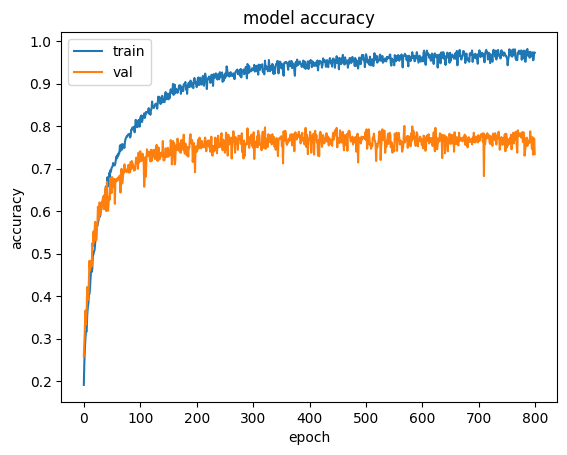

In [44]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
model.save('./Datasets/Classifiers/speech/mlp')

INFO:tensorflow:Assets written to: ./Datasets/Classifiers/speech/mlp\assets
